In [76]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import IPython
import math

In [77]:
def biquad_peaking(fs, f0, Q, gain_db):
    """Generates biquad coefficients for a peaking EQ filter."""
    A = 10**(gain_db / 40)  # Convert dB gain to linear amplitude
    omega = 2 * np.pi * f0 / fs
    alpha = np.sin(omega) / (2 * Q)

    b0 = 1 + alpha * A
    b1 = -2 * np.cos(omega)
    b2 = 1 - alpha * A
    a0 = 1 + alpha / A
    a1 = -2 * np.cos(omega)
    a2 = 1 - alpha / A

    return np.array([b0, b1, b2]), np.array([a0, a1, a2])

def apply_filter(x, b, a):
    """Applies a biquad filter to a signal."""
    return signal.lfilter(b, a, x)


In [78]:
def apply_parametric_eq(x, fs, eq_bands):

    # Apply each filter sequentially
    y = x.copy()
    for f0, Q, gain in eq_bands:
        b, a = biquad_peaking(fs, f0, Q, gain)
        y = signal.lfilter(b, a, y)  # Apply the filter

    return y

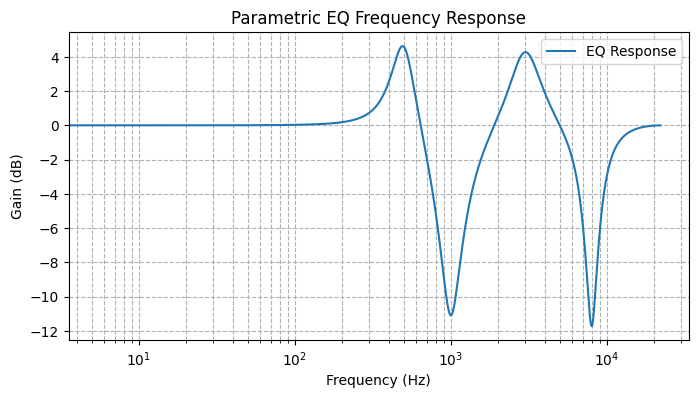

In [79]:
# Sampling rate
fs = 44100  

# Define four peaking EQ bands (center frequency, Q, gain in dB)
eq_bands = [
    (500,  2.0, 6),   # Peak at 500 Hz with +6 dB gain
    (1000, 2.0, -12),  # Dip at 1 kHz with -4 dB gain
    (3000, 1.5, 5),   # Peak at 3 kHz with +5 dB gain
    (8000, 3.0, -12)   # Dip at 8 kHz with -12 dB gain
]

# Generate frequency response
w, h_total = signal.freqz([1], [1], worN=4096, fs=fs)  # Start with a flat response

for f0, Q, gain in eq_bands:
    b, a = biquad_peaking(fs, f0, Q, gain)
    w, h = signal.freqz(b, a, worN=4096, fs=fs)
    h_total *= h  # Multiply responses to get the final EQ shape

# Plot EQ curve
plt.figure(figsize=(8, 4))
plt.semilogx(w, 20 * np.log10(abs(h_total)), label="EQ Response")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (dB)")
plt.title("Parametric EQ Frequency Response")
plt.grid(True, which="both", linestyle="--")
plt.legend()
plt.show()

In [80]:
from scipy.io import wavfile

samplerate, data = wavfile.read('guitare.wav')
t = np.arange(len(data)) / samplerate

# Apply the parametric EQ
y = apply_parametric_eq(data, samplerate, eq_bands)

In [81]:
wavfile.write('eq_ad_test.wav', int(samplerate), y.astype(np.int16))

In [82]:
IPython.display.Audio('guitare.wav')

In [83]:
IPython.display.Audio('eq_ad_test.wav')

In [84]:
def compute_fir_from_iir(fs, eq_bands, fir_order):
    """Approximates the IIR parametric EQ using the DFT method."""
    
    N = fir_order  # Number of frequency samples (must match FIR order)
    H = np.ones(N, dtype=complex)  # Initialize flat frequency response

    for f0, Q, gain in eq_bands:
        b, a = biquad_peaking(fs, f0, Q, gain)
        B = np.fft.fft(b, N)  # Compute DFT of numerator
        A = np.fft.fft(a, N)  # Compute DFT of denominator
        H *= B / A  # Compute H(e^jw) = DFT(b) / DFT(a)
    
    # Compute the FIR impulse response by taking the inverse DFT
    h_fir = np.fft.ifft(H).real  # Use only real part
    
    # Shift impulse response to be centered
    h_fir = np.roll(h_fir, -N // 2)
    
    # Apply a window to reduce spectral leakage
    h_fir *= np.hamming(N)

    return h_fir

In [85]:
def apply_fir_filter(x, h_fir):
    """Applies the FIR filter to a signal."""
    return np.convolve(x, h_fir, mode='same')

In [86]:
n_fir = 13
fir_order = 2**n_fir
h_fir = compute_fir_from_iir(fs, eq_bands, fir_order)

y_fir = apply_fir_filter(data, h_fir)
wavfile.write('eq_ad_fir.wav', int(samplerate), y_fir.astype(np.int16))

In [87]:
IPython.display.Audio('eq_ad_fir.wav')

In [88]:
IPython.display.Audio('guitare.wav')

In [89]:
IPython.display.Audio('eq_ad_test.wav')

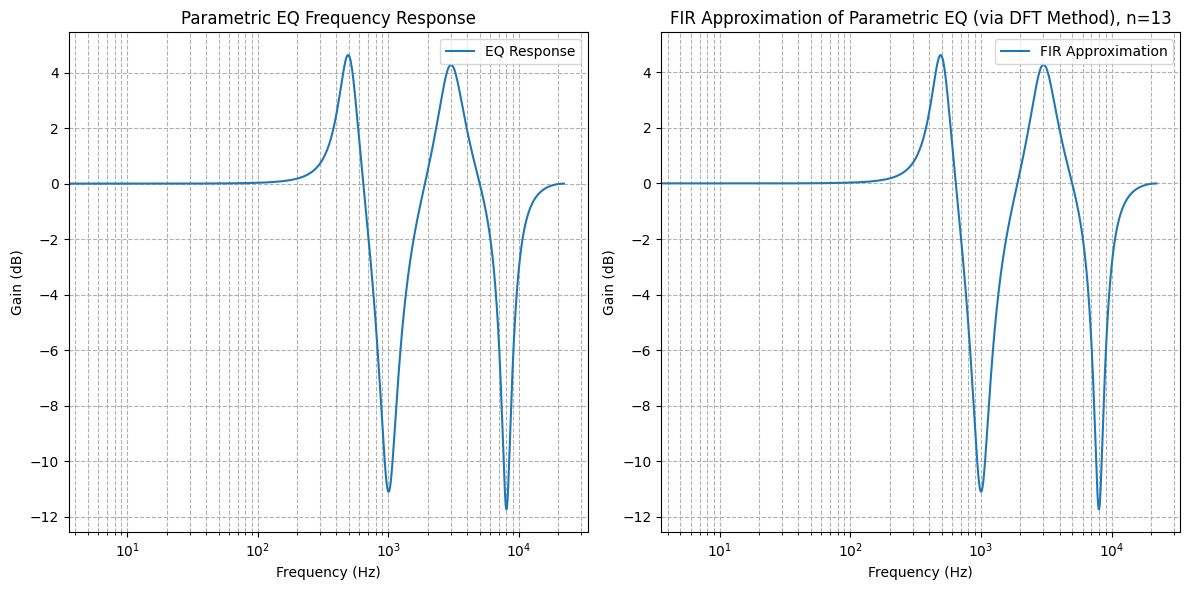

In [90]:
w_fir = np.fft.fftfreq(fir_order, d=1/fs)[:fir_order//2]  # Frequency axis
H_fir = np.fft.fft(h_fir, fir_order)[:fir_order//2]   # FIR response

plt.figure(figsize=(12, 6))

# First subplot
plt.subplot(1, 2, 1)
plt.semilogx(w, 20 * np.log10(abs(h_total)), label="EQ Response")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (dB)")
plt.title("Parametric EQ Frequency Response")
plt.grid(True, which="both", linestyle="--")
plt.legend()
# Second subplot
plt.subplot(1, 2, 2)
plt.semilogx(w_fir, 20 * np.log10(np.abs(H_fir)), label="FIR Approximation")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (dB)")
plt.title(f"FIR Approximation of Parametric EQ (via DFT Method), n={n_fir}")
plt.grid(True, which="both", linestyle="--")
plt.legend()

plt.tight_layout()
plt.savefig("n=13.svg")
plt.show()